# Policy Gradients (within Discrete Actions)

In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [2]:
# Function to render in notebook
def render_frame(env):
    frame = env.render()  # Returns the rendered frame as an RGB array
    plt.imshow(frame)
    plt.axis('off')  # Hide axis for better visualization
    clear_output(wait=True)  # Clear the previous frame
    plt.show()

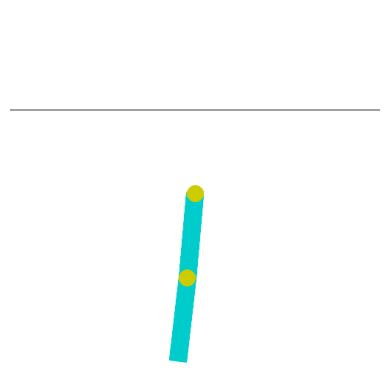

In [3]:
# Initialize the environment
env = gym.make("Acrobot-v1", render_mode="rgb_array")
state, info = env.reset()

render_frame(env)

### Goal 
- The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

### Observation Space
- The observation is a ndarray with shape (6,) of continuous variables
    - cos(theta1) [-1, 1]
    - sin(theta1) [-1, 1]
    - cos(theta2) [-1, 1]
    - sin(theta2) [-1, 1]
    - Angular velocity of theta1 (-4$\pi$, 4$\pi$)
    - Angular velocity of theta2 (-9$\pi$, 9$\pi$)

where: 
- theta1 is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.
- theta2 is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

### Action
- 3 possible discrete actions:
    - 0: apply -1 torque to the actuated joint (N/m)
    - 1: apply 0 torque to the actuated joint (N/m)
    - 2: apply +1 torque to the actuated joint (N/m)

### Reward
- -1 for each step

### End of episode
- The free end reaches the line or after 500 timesteps

### Random Policy

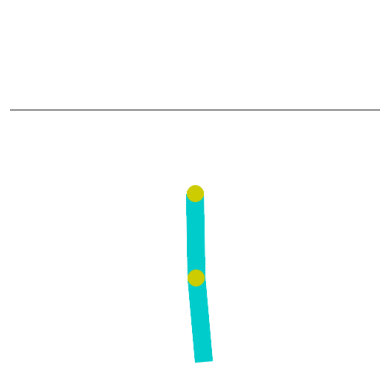

In [4]:
# visualize random policy

env = gym.make("Acrobot-v1", render_mode="rgb_array")
state, info = env.reset()

for _ in range(100):
    state, reward, done, _, info = env.step(env.action_space.sample())
    render_frame(env)

env.close()

In [5]:
env.observation_space, env.action_space

(Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32),
 Discrete(3))

## Policy Network for Discrete Actions

![policy_network](img/policy_network_discrete.png)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, num_actions):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(obs_size, 32)
        self.layer2 = nn.Linear(32, num_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        logits = self.layer2(x)
        probabilities = F.softmax(logits, dim=-1)
        
        pi = Categorical(probabilities)
        action = pi.sample()
        
        return action, pi

In [7]:
p_network = PolicyNetwork(obs_size=6, num_actions=3)
action, pi = p_network(torch.tensor(state))
action

tensor(1)

In [8]:
pi.sample()

tensor(2)

In [9]:
pi.log_prob(action)

tensor(-1.1057, grad_fn=<SqueezeBackward1>)

## Reinforce

![reinforce](img/reinforce.png)

Fun Fact: REINFORCE is an acronym for “ ‘RE’ward ‘I’ncrement ‘N’on-negative ‘F’actor times ‘O’ffset ‘R’einforcement times ‘C’haracteristic ‘E’ligibility

In [10]:
def reinforce(env, gamma=0.99, learning_rate=0.001, num_episodes=1000, training_episodes=4):

    """
    A small difference with the pseudo code above is that in practice we generate multiple episodes
    (controlled by "training_episodes") and compute a mean loss for all the collected esperiences. 
    This simple trick can help to reduce the high variance in Vanilla Policy Gradient traning. 
    """
    
    obs_size = env.observation_space.shape[0]
    num_actions = env.action_space.n  # For discrete action spaces
    p_network = PolicyNetwork(obs_size=obs_size, num_actions=num_actions)
    optimizer = torch.optim.Adam(p_network.parameters(), lr=learning_rate)

    episode_returns = []
    for episode in range(1, num_episodes + 1):
        rewards = [] # (num_training_episodes, episode_length)
        states = [] # (num_training_episodes*episode_length)
        actions = [] # (num_training_episodes*episode_length)

        for _ in range(training_episodes):
            state, info = env.reset()
            done = False
            ep_rewards = []
            while not done:
                
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32)
                    action, pi = p_network(state_tensor)
                    
                    states.append(state_tensor)
                    actions.append(action)
                    
                    state, reward, done, truncated, _ = env.step(action.item())
                    done = done or truncated
                    ep_rewards.append(reward)

            rewards.append(ep_rewards)
            episode_returns.append(sum(ep_rewards))

        # Compute discounted returns
        returns = []
        for i in range(training_episodes):
            R = 0
            ep_returns = []
            for r in reversed(rewards[i]):
                R = r + gamma * R
                ep_returns.insert(0, R)
            returns.extend(ep_returns)

        # (num_training_episodes*episode_length)
        returns = torch.tensor(returns, dtype=torch.float32)

        # Compute PG loss and optimize
        _, pi = p_network(torch.stack(states))
        log_probs = pi.log_prob(torch.stack(actions))
        loss = -torch.mean(log_probs * returns)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log
        if episode % 100 == 0:
            print(f'Episode {episode}, Loss: {loss:.2f}, Average Return: {np.mean(episode_returns[-100:])}')

    return p_network, episode_returns

In [11]:
%%time
p_network, returns = reinforce(env, num_episodes=1000, training_episodes=4)

Episode 100, Loss: -87.75, Average Return: -500.0
Episode 200, Loss: -87.60, Average Return: -500.0
Episode 300, Loss: -86.65, Average Return: -500.0
Episode 400, Loss: -86.48, Average Return: -499.4
Episode 500, Loss: -83.24, Average Return: -495.04
Episode 600, Loss: -86.47, Average Return: -498.14
Episode 700, Loss: -84.53, Average Return: -479.62
Episode 800, Loss: -77.21, Average Return: -371.24
Episode 900, Loss: -51.13, Average Return: -206.63
Episode 1000, Loss: -52.24, Average Return: -148.13
CPU times: user 19min 19s, sys: 3min 46s, total: 23min 5s
Wall time: 3min 33s


Text(0, 0.5, 'Returns')

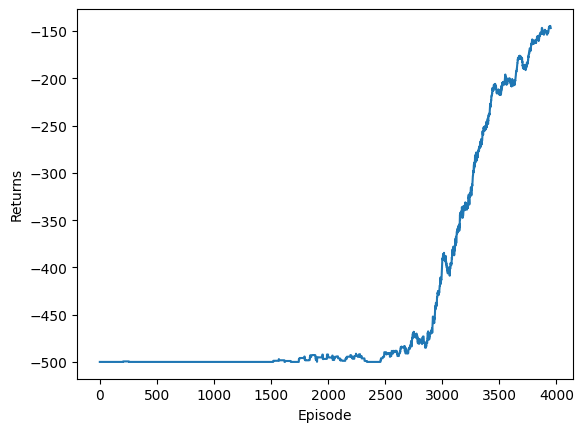

In [12]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(returns))
plt.xlabel('Episode')
plt.ylabel('Returns')

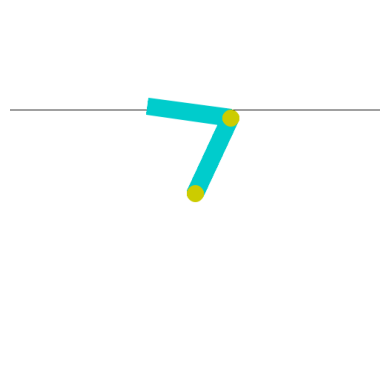

-130.0


In [13]:
state, info = env.reset()
render_frame(env)
done = False

r = 0
while not done:

    with torch.no_grad():
        action, _ = p_network(torch.tensor(state))
        
    state, reward, done, truncated, _ = env.step(action)
    done = done or truncated
    render_frame(env)
    r += reward

print(r)